In [1]:
from pydrake.all import (MathematicalProgram, Solve, MonomialBasis,
                         DiagramBuilder, Evaluate, LogVectorOutput, Simulator,
                         SymbolicVectorSystem, Variable, ToLatex, Polynomial,
                         VectorSystem, eq, ge, le, Formula, Expression, Evaluate,
                         LeafSystem, AbstractValue,
                         )

from pydrake.all import (PiecewisePolynomial, ModelInstanceIndex,
    RotationMatrix, RigidTransform, Rgba, Box, Sphere, BaseField,
    Evaluate, Fields, PointCloud, MeshcatAnimation)

from IPython.display import clear_output

import os
import copy
import time
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from dataclasses import dataclass
from dccm_quasistatic.utils.math_utils import (create_square_symmetric_matrix_from_lower_tri_array,
                                               get_n_lower_tri_from_matrix_dim,
                                               matrix_inverse)
from dccm_quasistatic.utils.sample_generator import (SampleGenerator, SampleGeneratorParams)
from dccm_quasistatic.controller.dccm_params import DCCMParams


from qsim.parser import (
    QuasistaticParser,
    QuasistaticSystemBackend,
    GradientMode,
)

from qsim.simulator import ForwardDynamicsMode, InternalVisualizationType
from qsim.model_paths import models_dir

/home/shaoyuan/Documents/Software/quasistatic_simulator/robotics_utilities/qp_derivatives/qp_derivatives.py:2: DrakeDeprecationWarning: Please import from the pydrake.solvers module directly, instead of the deprecated pydrake.solvers.mathematicalprogram submodule. The deprecated code will be removed from Drake on or after 2023-05-01.
  import pydrake.solvers.mathematicalprogram as mp


In [2]:
def display_expression(label:str, expr):
    display(
        Markdown(
            f"${label} = "
            + ToLatex(
                Polynomial(expr)
                .RemoveTermsWithSmallCoefficients(1e-5)
                .ToExpression(),
                6,
            )
            + "$"
        )
    )

In [3]:
class DCCMSystem():
    def __init__(self, params: DCCMParams):
        self._params = params
        self._wijc = None
        self._lijc = None
        
    def control_law(self, xk: np.array, xd: np.array, ud: np.array, t: float = 0):
        
        assert (self._wijc is not None) and (self._lijc is not None), "DCCM has not been calculated"
        print(f"Calculating geodesic at time: {t}, xk = {xk}, xd = {xd}, ud = {ud}")
        start_time = time.time()
        succeeded, xi, delta_xs, delta_s, geodesic = self.calculate_geodesic(xd, xk)
        if not succeeded:
            print(f"Geodesic calculation failed at time: {t}, u = {ud}")
            return ud, geodesic, succeeded
    
        x = [Variable(f"x_{i}") for i in range(self._params.dim_x)]
        v = [monomial.ToExpression() for monomial in MonomialBasis(x, self._params.deg)] # might need to wrap x in Variables()

        # Probably need to set this u* to something else!
        u = ud
        for i in range(self._params.n_geodesic_segments):
            # Create mapping of variables to values
            env = dict(zip(x, xi[i]))
            # Substitute xi into v(xi)
            v_xi = Evaluate(v, env).flatten()
            # Construct L(xi)
            Li_elements = self._lijc.dot(v_xi)
            Li = Li_elements.reshape(self._params.dim_u, self._params.dim_x)
            # Construct W(xi)
            Wi_lower_tri = self._wijc.dot(v_xi)
            # print(f"Wk_lower_tri.shape: {Wk_lower_tri.shape}")

            Wi = create_square_symmetric_matrix_from_lower_tri_array(Wi_lower_tri)
            # Get M(xi) by inverting W(xi)
            Mi = np.linalg.inv(Wi)
            # Add marginal control input to u
            u = u + delta_s[i] * Li @ Mi @ delta_xs[i]
        
        print(f"Geodesic calculation succeeded at time: {t}, u = {u}, calculation took {time.time() - start_time} seconds")

        return u, geodesic, succeeded

    def calculate_geodesic(self, x0, x1):
        """
        Calculate the geodesic from x0 to x1.
        Based on optimization (27)
        Args:
            x0: (dim_x,): initial state, will correspond to x_k
            x1: (dim_x,): final state, will correspond to x*_k
        """
        print("calculate_geodesic initialize")
        start_time = time.time()
        prog = MathematicalProgram()
        
        # Numerical state evaluation along the geodesic
        x = prog.NewContinuousVariables(self._params.n_geodesic_segments + 1, self._params.dim_x, 'x')

        # For getting around inverting W(x_i)
        m = prog.NewContinuousVariables(self._params.n_geodesic_segments, self._params.dim_x * self._params.dim_x, 'm')

        # For optimizing over the epigraph instead of the original objective
        y = prog.NewContinuousVariables(self._params.n_geodesic_segments, 'y')

        # Displacement vector discretized wrt s parameter
        delta_xs = prog.NewContinuousVariables(self._params.n_geodesic_segments, self._params.dim_x, '\delta x_s')
        
        # Small positive scaler value
        delta_s = prog.NewContinuousVariables(self._params.n_geodesic_segments, 's')

        # Add constraint: make sure delta_s's are positive
        si_positive = prog.AddLinearConstraint(ge(delta_s, np.ones_like(delta_s) * 1e-6))

        # Add constraints
        # Constraint 1
        si_sum_to_one = prog.AddLinearConstraint(sum(delta_s) == 1)
        discrete_distances_sum = x0
        # Constraint: Initial state matches x0
        prog.AddConstraint(eq(x[0], x0))
        for i in range(self._params.n_geodesic_segments):
            discrete_distances_sum = discrete_distances_sum + delta_s[i] * delta_xs[i]
            # Constraint 2: Intermediate state matches sum of deltas

            prog.AddConstraint(eq(x[i+1], discrete_distances_sum))
        # Constraint 3
        total_distances_match = prog.AddConstraint(eq(discrete_distances_sum, x1))
        # Sum cost over all segments
        prog.AddCost(np.sum(y))
        # Constraints for the values of y
        
        for i in range(self._params.n_geodesic_segments):
            v = [monomial.ToExpression() for monomial in MonomialBasis(x[i], self._params.deg)]
            # Construct W(x_i)
            Wk_lower_tri = self._wijc.dot(v)
            Wi = create_square_symmetric_matrix_from_lower_tri_array(Wk_lower_tri)

            # Mi = matrix_inverse(Wi) # <= because of the division, this is not a polynomial anymore.
            Mi = m[i].reshape(self._params.dim_x, self._params.dim_x) 
            MiWi = Mi @ Wi
            # WiMi = Wi @ Mi
            for j in range(self._params.dim_x):
                for k in range(self._params.dim_x):
                    if j == k:
                        prog.AddConstraint(MiWi[j, k] == 1)
                        # prog.AddConstraint(WiMi[j, k] == 1)
                    else:
                        prog.AddConstraint(MiWi[j, k] == 0)
                        # prog.AddConstraint(WiMi[j, k] == 0)
            metric_dist = delta_s[i] * delta_xs[i].T @ Mi @ delta_xs[i]
            # print(f"metric_dist: {metric_dist}")
            # print(f"metric_dist.is_polynomial(): {metric_dist.is_polynomial()}")
            # print(f"metric_dist type: {type(metric_dist)}")
            y_constraint = prog.AddConstraint(metric_dist <= y[i])
            # prog.AddConstraint(metric_dist >= 0)
            
            y_constraint.evaluator().set_description(f"y_constraint_{i}")
            
        
        # Try to keep delta_s small
        prog.AddCost(np.sum(delta_s**2))

        # Seed initial guess as all 1's so that determinant will not be 0 and cause a failure
        prog.SetInitialGuessForAllVariables(np.ones(prog.num_vars()))
        prog.SetInitialGuess(delta_s, np.ones_like(delta_s) * 1 / self._params.n_geodesic_segments)
        evenly_spaced_delta = (x1 - x0) / self._params.n_geodesic_segments
        for i in range (self._params.n_geodesic_segments):
            prog.SetInitialGuess(delta_xs[i],  i * evenly_spaced_delta)
            prog.SetInitialGuess(x[i], x0 + i * evenly_spaced_delta)
        print("Start solving geodesic, time taken to setup: ", time.time() - start_time, " seconds")
        start_time = time.time()
        result = Solve(prog)
        print("Solver succeeded: ", result.is_success(), " in ", time.time() - start_time, " seconds")

        # infeasible_constraints = result.GetInfeasibleConstraints(prog)
        # for c in infeasible_constraints:
        #     print(f"infeasible constraint: {c}")

        geodesic_length = np.sum(result.GetSolution(y))
        return result.is_success(), result.GetSolution(x), result.GetSolution(delta_xs), result.GetSolution(delta_s), geodesic_length
    
    def calculate_dccm_from_samples(self, x_samples, u_samples, x_next_samples, A_samples, B_samples, wijc_initial_guess = None, lijc_initial_guess = None) -> None:
        n_dccm_samples = len(x_samples)
        start_time = time.time()
        print(f"Calculating DCCM from {n_dccm_samples} samples")
        prog = MathematicalProgram()
        # Indeterminates
        x = prog.NewIndeterminates(self._params.dim_x, 'x{k}')
        u = prog.NewIndeterminates(self._params.dim_u, 'u{k}')
        w = prog.NewIndeterminates(self._params.dim_x * 2, 'w')
        w = np.array(w).reshape(-1, 1)

        # Monomial basis
        v = [monomial.ToExpression() for monomial in MonomialBasis(x, self._params.deg)]

        dim_v = len(v)
        # print(f"dim_v: {dim_v}")
        # for vi in v:
        #     display_expression("v_i", vi)
        
        n_lower_tri = get_n_lower_tri_from_matrix_dim(self._params.dim_x)
        wijc = prog.NewContinuousVariables(rows=n_lower_tri, cols=dim_v, name='wijc')
        # print(f"n_lower_tri: {n_lower_tri}")
        # print("wijc: ", wijc.shape)

        lijc = prog.NewContinuousVariables(rows=self._params.dim_x * self._params.dim_u, cols=dim_v, name='lijc')
        # print("lijc: ", lijc.shape)

        r = prog.NewContinuousVariables(1, 'r')

        for i in range(n_dccm_samples):
            xi = x_samples[i]
            ui = u_samples[i]
            # A and B matrices
            Ak = A_samples[i]
            Bk = B_samples[i]

            # Create mapping of variables to values
            env = dict(zip(x, xi))
            # Substitute xi into v(xi)
            v_xi = Evaluate(v, env).flatten()

            xi_next = x_next_samples[i]
            # Create mapping of variables to values
            env = dict(zip(x, xi_next))
            # Substitute xi_next into v(xi_next)
            v_xi_next = Evaluate(v, env).flatten()
            # print(f"v_xi.shape: {v_xi.shape}")

            Wk_lower_tri = wijc.dot(v_xi)
            # print(f"Wk_lower_tri.shape: {Wk_lower_tri.shape}")

            Wk = create_square_symmetric_matrix_from_lower_tri_array(Wk_lower_tri)
            # Wk has shape (dim_x, dim_x)

            Wk_next_lower_tri = wijc.dot(v_xi_next)
            Wk_next = create_square_symmetric_matrix_from_lower_tri_array(Wk_next_lower_tri)


            Lk_elements = lijc.dot(v_xi)
            Lk = Lk_elements.reshape(self._params.dim_u, self._params.dim_x)

            # print("Wk: ", Wk.shape)
            # print("Wk_next: ", Wk_next.shape)
            # print("Ak: ", Ak.shape)
            # print("Bk: ", Bk.shape)
            # print("Lk: ", Lk.shape)

            print("Adding constraint for sample ", i)
            clear_output(wait=True)
            cross_diag = Ak @ Wk + Bk @ Lk
            omega = np.block([[Wk_next, cross_diag],
                            [cross_diag.T, (1-self._params.beta)*Wk]])
            # print("omega: ", omega.shape)
            # Note: w is an additional indeterminate that enforces that omega is PSD

            prog.AddSosConstraint((w.T @ omega @ w - r[0] * w.T @  w).flatten()[0])
            

        prog.AddLinearCost(r[0])
        prog.AddLinearConstraint(r[0] >= 0.01)
        # print(f"num_vars: {prog.num_vars()}")
        # print(f"num_indeterminates: {prog.num_indeterminates()}")

        if wijc_initial_guess is not None:
            prog.SetInitialGuess(wijc, wijc_initial_guess)
        if lijc_initial_guess is not None:
            prog.SetInitialGuess(lijc, lijc_initial_guess)

        print("Start solving DCCM")
        result = Solve(prog)
        print("Solver succeeded: ", result.is_success(), " in ", time.time() - start_time, " seconds")

        infeasible_constraints = result.GetInfeasibleConstraints(prog)
        for c in infeasible_constraints:
            print(f"infeasible constraint: {c}")

        # print('solver is: ', result.get_solver_id().name())

        # Extract the solution
        self._wijc = result.GetSolution(wijc)
        self._lijc = result.GetSolution(lijc)
        print("wijc:\n", self._wijc)
        print("\nlijc:\n", self._lijc)
        print("r:\n", result.GetSolution(r))
        return result.is_success()

In [4]:
sample_generator_params = SampleGeneratorParams(
    log_barrier_weight=10,
    n_samples=2000,
    workspace_radius=2,
    actuated_collision_geomtery_names=["hand::collision"]
)

dccm_params = DCCMParams(
    time_step=None,
    pid_gains=None,
    robot_urdf_path=None,
    dim_x=5,
    dim_u=2,
    deg=4,
    beta=0.1,
    n_geodesic_segments=3,
)
q = np.array([-0.5, 0, 0, -1.5, 0]) # [box_x, box_y, box_theta, sphere_x, sphere_y]
q_desired = np.array([0, 0, 0, -0.6, 0]) # [box_x, box_y, box_theta, sphere_x, sphere_y]

# q = np.array([0, 0.5, 0.1, -1.5, 0]) # [box_x, box_y, box_theta, sphere_x, sphere_y]
# q_desired = np.array([0, 0, 0, 0, -1]) # [box_x, box_y, box_theta, sphere_x, sphere_y]

q_model_path = os.path.join(models_dir, "q_sys", "box_pushing.yml")
q_parser = QuasistaticParser(q_model_path)
q_sim = q_parser.make_simulator_cpp()
q_sim_py = q_parser.make_simulator_py(InternalVisualizationType.Cpp)

q_sim_py.update_mbp_positions_from_vector(q)
q_sim_py.draw_current_configuration()

file_prefix = "saved_dccm_coeffs/circ_"
base_filename = f"samples{sample_generator_params.n_samples}_lbw{sample_generator_params.log_barrier_weight}_wr{sample_generator_params.workspace_radius}_deg{dccm_params.deg}_beta{str(dccm_params.beta).split('.')[1]}.npy"

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [5]:
# sample_generator = SampleGenerator(sample_generator_params, q_sim=q_sim, q_sim_py=q_sim_py, parser=q_parser)
# samples = sample_generator.generate_circular_traj_samples(visualize=False)

# dccm_system = DCCMSystem(dccm_params)
# success = dccm_system.calculate_dccm_from_samples(*samples)
# if success:
#     np.save(f"{file_prefix}wijc_{base_filename}", dccm_system._wijc)
#     np.save(f"{file_prefix}lijc_{base_filename}", dccm_system._lijc)

# Convex program so should not require initial guess
# initial_guess_base_filename = f"samples{2000}_lbw{sample_generator_params.log_barrier_weight}_wr{sample_generator_params.workspace_radius}_deg{dccm_params.deg}.npy"
# wijc_initial_guess = np.load(f"{file_prefix}wijc_{initial_guess_base_filename}")
# lijc_initial_guess = np.load(f"{file_prefix}lijc_{initial_guess_base_filename}")
# success = dccm_system.calculate_dccm_from_samples(*samples, wijc_initial_guess, lijc_initial_guess)

In [6]:
dccm_system = DCCMSystem(dccm_params)
# Load the DCCM from file
dccm_system._wijc = np.load(f"{file_prefix}wijc_{base_filename}")
dccm_system._lijc = np.load(f"{file_prefix}lijc_{base_filename}")

print(f"wijc:\n{dccm_system._wijc}")
print(f"lijc:\n{dccm_system._lijc}")

wijc:
[[ 3.55451518e+01 -3.66134598e+01  7.83183928e+01 ... -7.34765562e+03
  -1.34867378e+03  1.05786854e+04]
 [-2.53514113e+00  1.59332826e+00  1.33644617e+00 ... -2.19793899e+03
   3.75435588e+02  2.26126624e+03]
 [ 3.81872574e+01 -1.64058175e+01  8.63494147e+01 ...  1.73465780e+02
  -2.02399307e+03  6.95229391e+03]
 ...
 [-1.44255071e+01  2.06951683e+01 -3.92413841e+01 ...  2.53498192e+04
  -2.94414784e+04 -1.44299788e+04]
 [ 1.30159985e+02  1.28171598e+03 -3.86776230e+02 ...  1.20473033e+04
   1.08715641e+05  1.20950772e+04]
 [ 1.24921599e+03 -3.83116929e+02  1.34884634e+03 ...  1.24286257e+04
  -6.55529009e+04  8.75684082e+04]]
lijc:
[[-2.43243782e+01  3.51496733e+01  5.01362938e+01 ... -1.23410886e+04
  -1.05634565e+04  1.32707738e+04]
 [-3.85380226e+00  9.33307221e+01 -7.76373108e+01 ... -2.13762482e+04
   4.40313275e+03  1.29338173e+04]
 [-4.61230209e+01 -1.29924253e+01 -8.24743673e+01 ...  2.22779181e+04
   5.46858334e+03 -1.32673901e+04]
 ...
 [-3.74408049e+01 -6.52806326e+0

In [7]:
sim_p = copy.deepcopy(q_sim.get_sim_params())
sim_p.h = 0.1
sim_p.unactuated_mass_scale = 10
# exact dynamics
# sim_p.gradient_mode = GradientMode.kNone
# sim_p.forward_mode = ForwardDynamicsMode.kQpMp
# Smoothed dynamics
sim_p.gradient_mode = GradientMode.kAB
sim_p.log_barrier_weight = sample_generator_params.log_barrier_weight
sim_p.forward_mode = ForwardDynamicsMode.kLogIcecream

meshcat = q_sim_py.meshcat

def draw_pose_of_box(name, pos, color):
    pose = RigidTransform(RotationMatrix().MakeXRotation(pos[-1]), np.concatenate(([0], pos[0:2])))
    
    meshcat.SetObject(name, Box(1,1,1), rgba=color)
    meshcat.SetTransform(name, pose)

def visualize_open_loop_traj(q0, q_desired):
    qs = [q0]
    q = q0
    for i, q_des in enumerate(q_desired):
        if i == len(q_desired) - 1:
            break
        u_desired = q_desired[i+1, -2:]
        b_des = q_des[:3]
        draw_pose_of_box("b_des", b_des, Rgba(0, 1, 0, 0.5))
        q_sim_py.update_mbp_positions_from_vector(q)
        q_sim_py.draw_current_configuration()
        time.sleep(0.1)
        q = q_sim.calc_dynamics(q, u_desired, sim_p)
        qs.append(q)
    return np.array(qs)
    
def make_desired_traj_achievable(q_desired):
    actual = [q_desired[0]]
    q = q_desired[0]
    for i, q_des in enumerate(q_desired):
        if i == len(q_desired) - 1:
            u_desired = q_desired[i, -2:]
        else:
            u_desired = q_desired[i+1, -2:]
        b_des = q_des[:3]
        q_sim_py.update_mbp_positions_from_vector(q)
        # q_sim_py.draw_current_configuration()
        # time.sleep(0.02)
        q = q_sim.calc_dynamics(q, u_desired, sim_p)
        actual.append(q)
    return np.array(actual)

# This trajectory of u_desired works open loop
# Most ideal trajectory for b_r = 1.2
def make_idealized_traj(b_r, s_r, theta_buff, n_steps):
    q_desired = []
    for i in range(n_steps):
        b_theta = np.pi * 2 * i / n_steps
        b_x = b_r * np.sin(b_theta)
        b_y = b_r * np.cos(b_theta)
        s_theta = b_theta - theta_buff
        s_x = s_r * np.sin(s_theta)
        s_y = s_r * np.cos(s_theta)
        q = np.array([b_x, b_y, -b_theta, s_x, s_y])
        q_desired.append(q)
        q_sim_py.update_mbp_positions_from_vector(q)
        # q_sim_py.draw_current_configuration()
        # time.sleep(0.03)
        # q_next = q_sim.calc_dynamics(q, q[-2:], sim_params)
        
        # q_sim_py.update_mbp_positions_from_vector(q_next)
        # q_sim_py.draw_current_configuration()
        # time.sleep(0.3)
    return np.array(q_desired)

n_steps = 100
b_r = 1.4
s_r = b_r + 1.3
theta_buff = 0.9
q_desired_1 = make_idealized_traj(b_r, s_r, theta_buff, n_steps)
q_desired_1 = make_desired_traj_achievable(np.array(q_desired_1))

# visualize_open_loop_traj(q_desired_1[0], q_desired_1)

b_r = 1.5
s_r = b_r + 1.1
theta_buff = 0.9
q_desired_2 = make_idealized_traj(b_r, s_r, theta_buff, n_steps)
q_desired_2 = make_desired_traj_achievable(np.array(q_desired_2))
# visualize_open_loop_traj(q_desired_2[0], q_desired_2)

# Splice the the two trajectories together
break_idx = int(n_steps/3)
# lower, higher, lower
# q_desired = np.concatenate((q_desired_1[:break_idx], q_desired_2[break_idx:break_idx*2], q_desired_1[break_idx*2:]), axis=0)
# higher, lower, higher
# q_desired = np.concatenate((q_desired_2[:break_idx], q_desired_1[break_idx:break_idx*2], q_desired_2[break_idx*2:]), axis=0)

break_idx = int(n_steps/2)
# lower, higher # this one seems to correct itself not a good example
# q_desired = np.concatenate((q_desired_1[:break_idx], q_desired_2[break_idx:]), axis=0)
# higher, lower # this is a pretty good test case, see if the controller can achieve lower error than this open loop traj
# traj A
q_desired = np.concatenate((q_desired_2[:break_idx], q_desired_1[break_idx:]), axis=0)
# q_desired = q_desired_2

initial_offset = np.array([0.2, -0.1, 0.1, 0.1, 0.2])
q = q_desired[0] + initial_offset
openloopqs = visualize_open_loop_traj(q, q_desired)
    


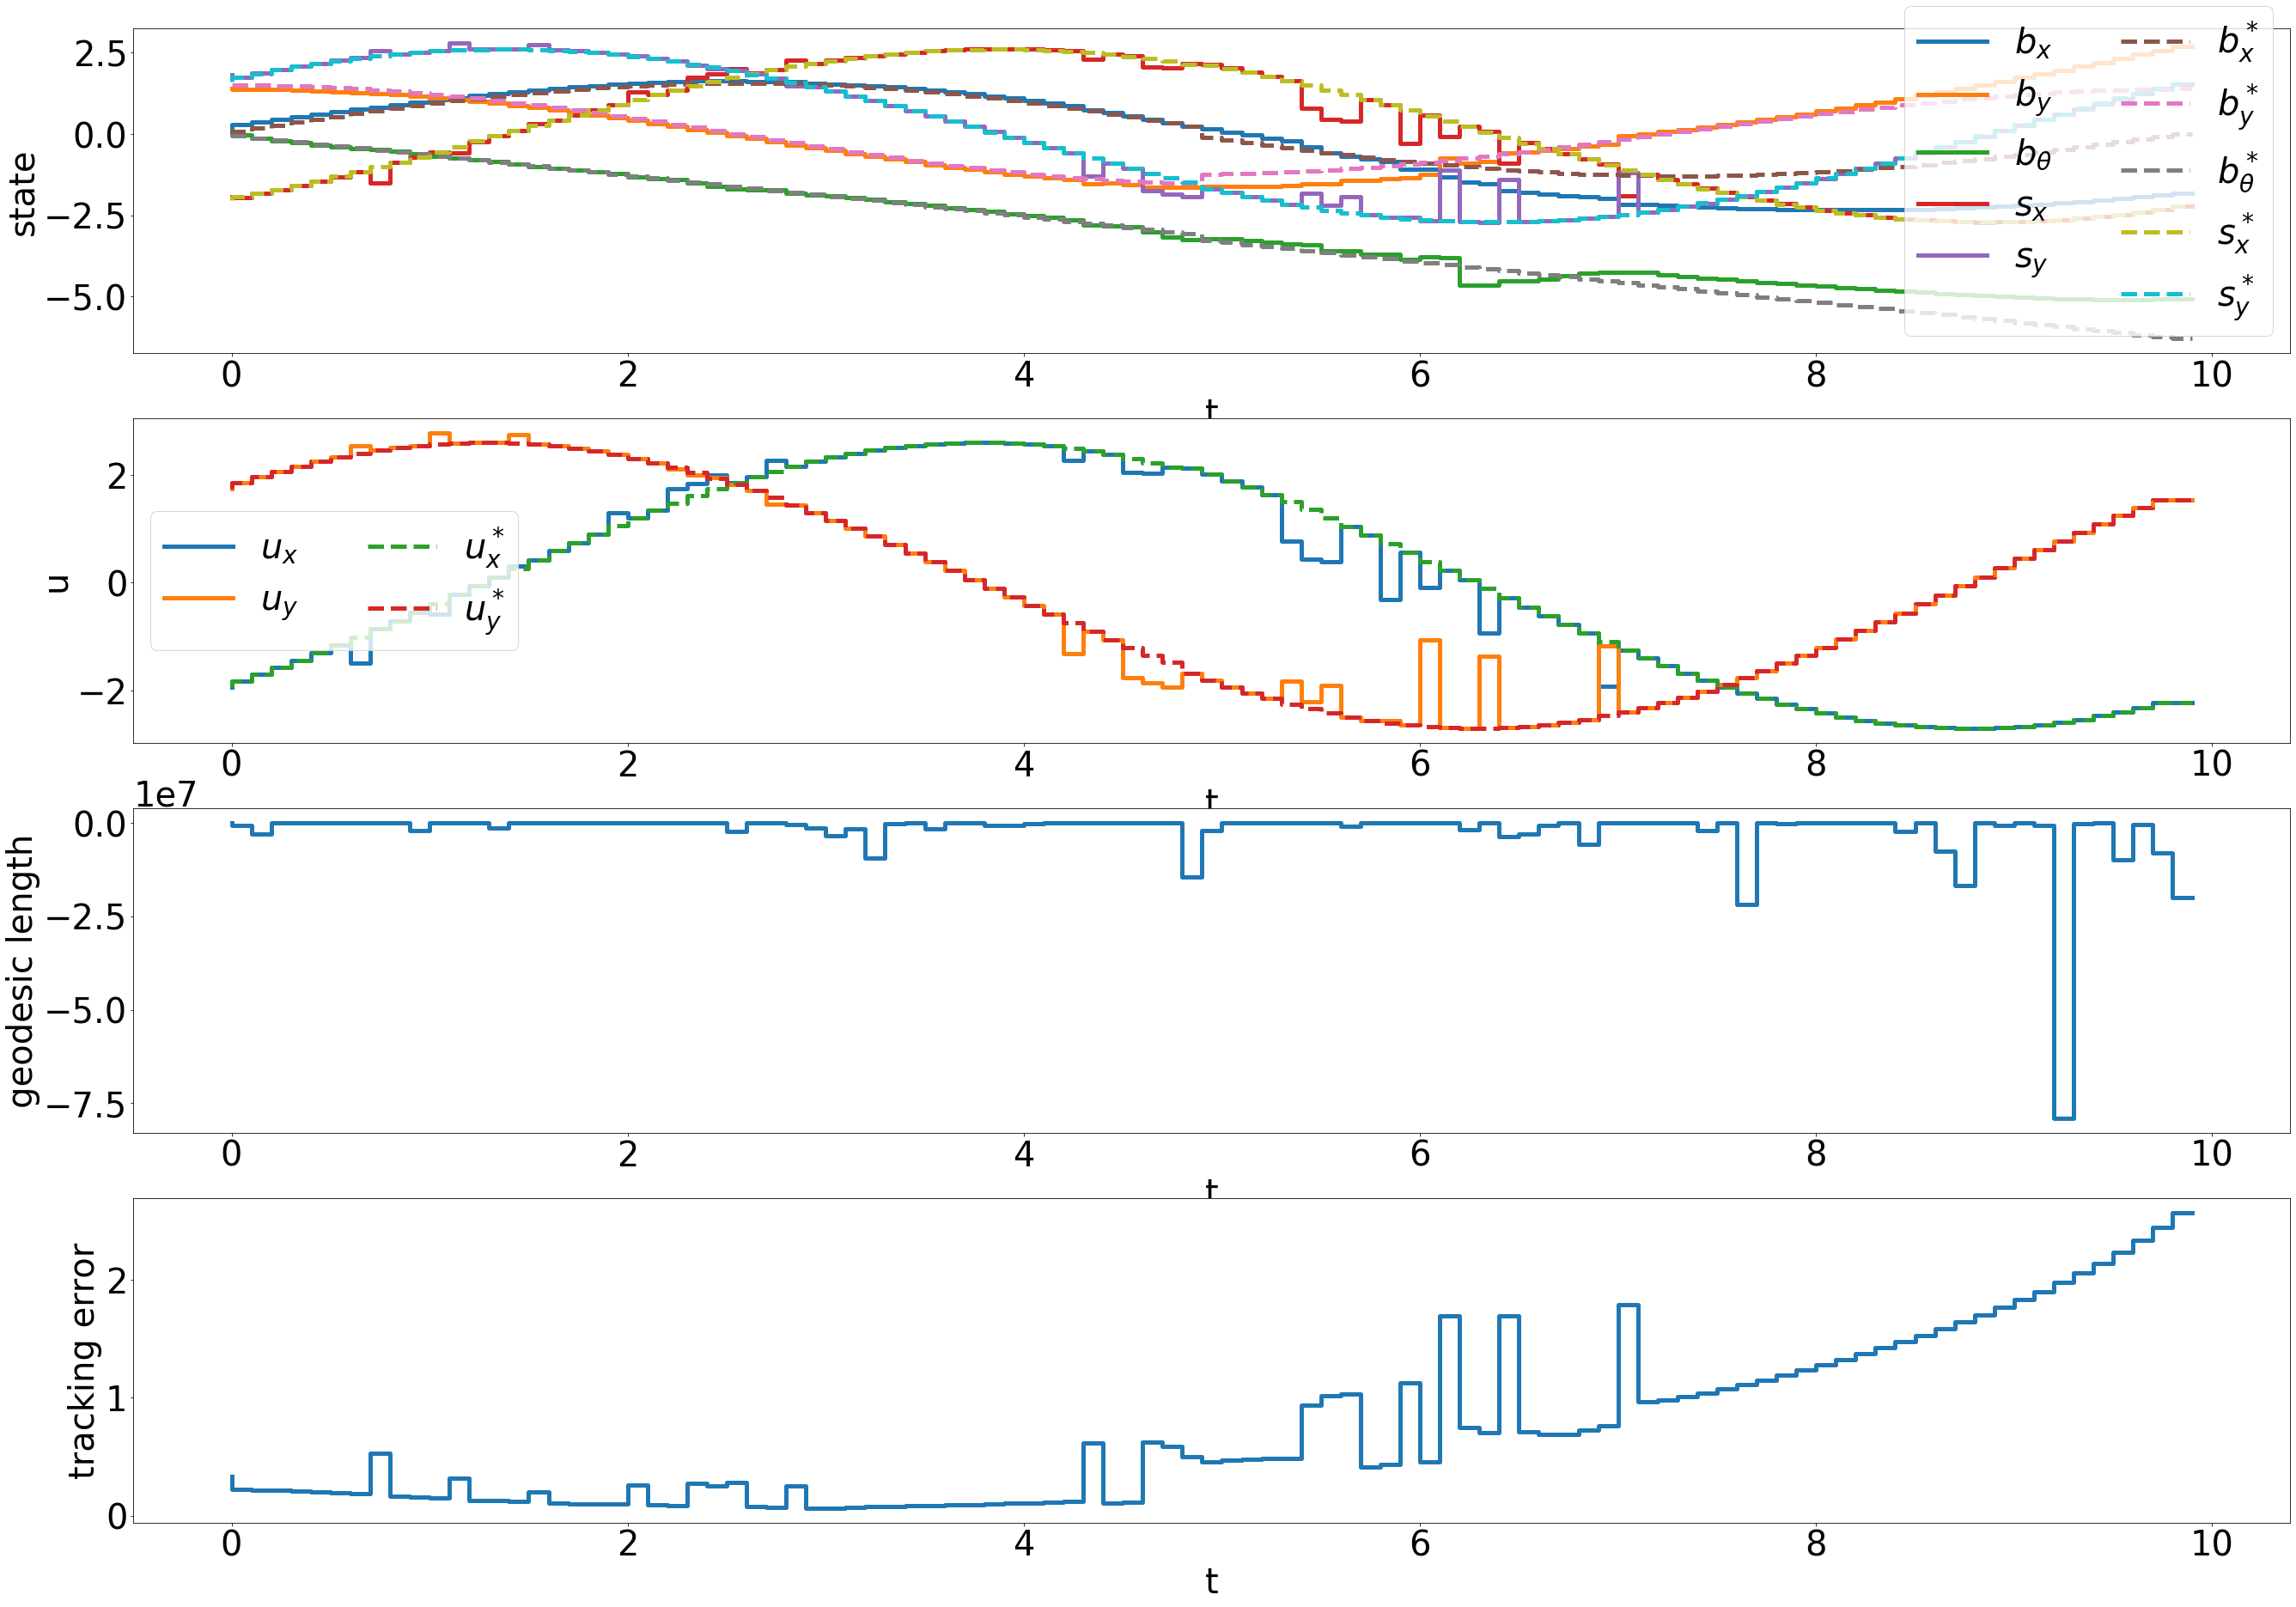

success: [False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, False, True, False, False, True, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, True, False, False, False, False, False, True, True, True, False, False, True, False, True, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
total tracking error:  71.82624809405864


In [8]:
total_duration_s = 10

# q_desired = np.array(q_desired)
# initial_offset = np.array([0.2, -0.1, 0.1, 0.1, 0.2])
# q = q_desired[0] + initial_offset

q_sim_py.update_mbp_positions_from_vector(q)
q_sim_py.draw_current_configuration()

n_steps = int(total_duration_s / sim_p.h)
t_log = []
q_log = []
u_log = []
u_desired_log = []
geodesic_log = []
success_log = []
tracking_error_log = []

plt.rcParams.update({'font.size': 40})
linewidth = 5
def draw_plot(t, q, q_des, u, u_des, geodesic, tracking_error):
    clear_output(wait=True)
    fig, axs = plt.subplots(4, 1, figsize=(45, 32))

    axis = axs[0]
    axis.step(t, q, linestyle='solid', linewidth=linewidth)
    axis.step(t, q_des, linestyle='dashed', linewidth=linewidth)
    axis.legend([r'$b_x$', r'$b_y$', r'$b_{\theta}$', r'$s_x$', r'$s_y$',
                 r'$b^*_x$', r'$b^*_y$', r'$b^*_{\theta}$', r'$s^*_x$', r'$s^*_y$'],
                 ncol=2)
    axis.set_ylabel('state')
    axis.set_xlabel('t')

    axis = axs[1]
    axis.step(t, u, linestyle='solid', linewidth=linewidth)
    axis.step(t, u_des, linestyle='dashed', linewidth=linewidth)
    axis.legend([r'$u_{x}$',r'$u_{y}$', r'$u^*_{x}$',r'$u^*_{y}$'],
                ncol=2)
    axis.set_ylabel('u')
    axis.set_xlabel('t')

    axis = axs[2]
    axis.step(t, geodesic, linewidth=linewidth)
    axis.set_ylabel('geodesic length')
    axis.set_xlabel('t')

    axis = axs[3]
    axis.step(t, tracking_error, linewidth=linewidth)
    axis.set_ylabel('tracking error')
    axis.set_xlabel('t')
    plt.show()

for i in range(n_steps):
    t=i*sim_p.h
    t_log.append(t)
    q_log.append(q)
    if i == len(q_desired) - 1:
        break
    u_desired = q_desired[i+1, -2:]
    tracking_error = np.linalg.norm(q - q_desired[i])
    tracking_error_log.append(tracking_error)
    # Dummy data
    # u = u_desired
    # geodesic = 0
    # success = True
    u, geodesic, success = dccm_system.control_law(q,q_desired[i, :], u_desired, t)
    q = q_sim.calc_dynamics(q, u, sim_p)
    q_sim_py.update_mbp_positions_from_vector(q)
    q_sim_py.draw_current_configuration()
    b_des = q_desired[i+1, :3]
    draw_pose_of_box("b_des", b_des, Rgba(0, 1, 0, 0.1))
    draw_pose_of_box("open loop b", openloopqs[i+1, :3], Rgba(1, 0, 0, 0.1))
    
    u_desired_log.append(u_desired)
    u_log.append(u)
    geodesic_log.append(geodesic)
    success_log.append(success)
    draw_plot(t_log, q_log, q_desired[:i+1, :], u_log, u_desired_log, geodesic_log, tracking_error_log)
    print(f"success: {success_log}")


print(f"total tracking error: ", np.sum(tracking_error_log))



In [9]:
import zarr
traj_id = "A"
results_file_name = f"results/circ_traj{traj_id}_ngeoseg_{dccm_params.n_geodesic_segments}_{base_filename}.zarr"
root = zarr.open_group(results_file_name, mode='w')

root["success"] = success_log
root["t"] = t_log
root["q_desired"] = q_desired
root["u_desired"] = u_desired_log
root["q"] = q_log
root["u"] = u_log
root["geodesic"] = geodesic_log
root["tracking_error"] = tracking_error_log


In [10]:
root = zarr.open_group(results_file_name, mode='a')
print(np.sum(root["tracking_error"]))
def get_arrays_from_root(root):
    success = root["success"]
    t = root["t"]
    q_desired = root["q_desired"]
    u_desired = root["u_desired"]
    q = root["q"]
    u = root["u"]
    geodesic = root["geodesic"]
    tracking_error = root["tracking_error"]
    return success, t, q_desired, u_desired, q, u, geodesic, tracking_error



71.82624809405864
